DATASET CLEANING

In [3]:
import pandas as pd
from urllib.parse import urlparse

In [ ]:
# Load CSV
df = pd.read_csv(r"D:\QRMODELTRAINING\backend\ORIGINALDATASET\balanced_urls.csv")

# Quick look at the data
df.head()

,URL,Label,Label_Encoded
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [5]:
from urllib.parse import urlparse

# Function to check URL validity
def is_valid_url(url):
    try:
        result = urlparse(url)
        # A URL is valid if it has a scheme (http/https) and a domain (netloc)
        return all([result.scheme, result.netloc])
    except:
        return False

# Apply validity check
df['is_valid'] = df['URL'].apply(is_valid_url)

# Count valid and invalid URLs
valid_count = df['is_valid'].sum()
invalid_count = len(df) - valid_count

print(f"Valid URLs: {valid_count}")
print(f"Invalid URLs: {invalid_count}")


Valid URLs: 562078
Invalid URLs: 70430


In [ ]:
# Keep only valid URLs
valid_df = df[df['is_valid']].reset_index(drop=True)

# Drop the 'is_valid' column if you want a clean CSV
valid_df = valid_df.drop(columns=['is_valid'])

# Save to new CSV
valid_df.to_csv(r"D:\QRMODELTRAINING\backend\CSVFILES\ValidUrls.csv", index=False)

print(f"Saved {len(valid_df)} valid URLs to 'ValidUrls.csv'")


Saved 562078 valid URLs to 'ValidUrls.csv'


AFTER REMOVING THE INVALID URLS. CHECK HOW MANY ARE SAFE AND MALICIOUS.

In [ ]:
import pandas as pd

# Load the cleaned CSV
valid_df = pd.read_csv(r"D:\QRMODELTRAINING\backend\CSVFILES\ValidUrls.csv")

# Count URLs by label
label_counts = valid_df['Label'].value_counts()

print("Number of URLs by label in 'ValidUrls.csv':")
print(label_counts)


Number of URLs by label in 'ValidUrls.csv':
Label
benign       316254
malicious    245824
Name: count, dtype: int64


NEXT IS TO TEST FEATURE EXTRACTION GRAPH WITHOUT WHOIS

In [ ]:
import pandas as pd
from urllib.parse import urlparse

# Load cleaned CSV
df = pd.read_csv(r"D:\QRMODELTRAINING\backend\CSVFILES\ValidUrls.csv")

# Normalize URLs
df['Label'] = df['Label'].str.lower()
df['URL_normalized'] = df['URL'].apply(lambda u: str(u).lower().rstrip('/').split('#')[0].split('?')[0].replace('www.', '', 1))

df.head()


,URL,Label,URL_normalized
0,https://www.google.com,benign,https://google.com
1,https://www.youtube.com,benign,https://youtube.com
2,https://www.facebook.com,benign,https://facebook.com
3,https://www.baidu.com,benign,https://baidu.com
4,https://www.wikipedia.org,benign,https://wikipedia.org


In [28]:
import re, math
from collections import Counter

SUSPICIOUS_KEYWORDS = {"login", "verify", "secure", "account", "update", 
                       "bank", "free", "bonus", "signin", "paypal"}

# Shannon entropy function
def shannon_entropy(s):
    if not s: return 0
    probs = [c/len(s) for c in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

# Feature extraction function
def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path

    url_length = len(url)
    has_ip = int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url)))
    has_at = int('@' in url)
    double_slash = int('//' in path)
    subdomain_count = len(domain.split('.')) - 2 if len(domain.split('.')) > 2 else 0
    https_token = int(url.startswith('https'))
    path_depth = len([p for p in path.split('/') if p])
    letters = sum(c.isalpha() for c in url)
    digits = sum(c.isdigit() for c in url)
    digit_letter_ratio = digits / letters if letters > 0 else 0
    special_chars = sum(not c.isalnum() for c in url)
    special_char_ratio = special_chars / len(url) if len(url) > 0 else 0
    repeated_char_count = sum(1 for i in range(1,len(url)) if url[i]==url[i-1])
    domain_entropy = shannon_entropy(domain)
    path_entropy = shannon_entropy(path)

    long_subdomain_length = max((len(p) for p in domain.split('.')[:-2]), default=0)
    url_has_suspicious_keywords = int(any(kw in url.lower() for kw in SUSPICIOUS_KEYWORDS))
    has_multiple_subdomains = int(subdomain_count > 1)

    return {
        'url_length': url_length,
        'subdomain_count': subdomain_count,
        'path_depth': path_depth,
        'digit_letter_ratio': digit_letter_ratio,
        'special_char_ratio': special_char_ratio,
        'repeated_char_count': repeated_char_count,
        'domain_entropy': domain_entropy,
        'path_entropy': path_entropy,
        'long_subdomain_length': long_subdomain_length,
        'has_ip': has_ip,
        'has_at': has_at,
        'double_slash': double_slash,
        'https_token': https_token,
        'url_has_suspicious_keywords': url_has_suspicious_keywords,
        'has_multiple_subdomains': has_multiple_subdomains
    }

# Extract features
lexical_features_df = pd.DataFrame([extract_features(u) for u in df['URL_normalized']])
df = pd.concat([df, lexical_features_df], axis=1)

df.tail(5)


,URL,Label,URL_normalized,url_length,subdomain_count,path_depth,digit_letter_ratio,special_char_ratio,repeated_char_count,domain_entropy,path_entropy,long_subdomain_length,has_ip,has_at,double_slash,https_token,url_has_suspicious_keywords,has_multiple_subdomains
562073,http://211.137.225.95:47475/Mozi.m,malicious,http://211.137.225.95:47475/mozi.m,34,2,1,1.777778,0.264706,4,3.033206,2.521641,3,1,0,0,0,0,1
562074,http://115.55.246.246:44661/Mozi.m,malicious,http://115.55.246.246:44661/mozi.m,34,2,1,1.777778,0.264706,6,2.708695,2.521641,3,1,0,0,0,0,1
562075,http://219.155.142.211:55621/Mozi.m,malicious,http://219.155.142.211:55621/mozi.m,35,2,1,1.888889,0.257143,5,2.665429,2.521641,3,1,0,0,0,0,1
562076,http://42.238.164.8:48848/Mozi.m,malicious,http://42.238.164.8:48848/mozi.m,32,2,1,1.555556,0.281250,3,2.705229,2.521641,3,1,0,0,0,0,1
562077,http://172.36.45.82:41684/Mozi.m,malicious,http://172.36.45.82:41684/mozi.m,32,2,1,1.555556,0.281250,2,3.197160,2.521641,3,1,0,0,0,0,1


In [30]:
# Encode labels for graphing or ML
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})
df.head()

,URL,Label,URL_normalized,url_length,subdomain_count,path_depth,digit_letter_ratio,special_char_ratio,repeated_char_count,domain_entropy,path_entropy,long_subdomain_length,has_ip,has_at,double_slash,https_token,url_has_suspicious_keywords,has_multiple_subdomains,Label_encoded
0,https://www.google.com,benign,https://google.com,18,0,0,0.0,0.222222,3,2.646439,0.0,0,0,0,0,1,0,0,0
1,https://www.youtube.com,benign,https://youtube.com,19,0,0,0.0,0.210526,2,3.095795,0.0,0,0,0,0,1,0,0,0
2,https://www.facebook.com,benign,https://facebook.com,20,0,0,0.0,0.200000,3,3.022055,0.0,0,0,0,0,1,0,0,0
3,https://www.baidu.com,benign,https://baidu.com,17,0,0,0.0,0.235294,2,3.169925,0.0,0,0,0,0,1,0,0,0
4,https://www.wikipedia.org,benign,https://wikipedia.org,21,0,0,0.0,0.190476,2,3.334679,0.0,0,0,0,0,1,0,0,0


In [31]:
# Numeric features
numeric_features = [
    'url_length',
    'subdomain_count',
    'path_depth',
    'digit_letter_ratio',
    'special_char_ratio',
    'repeated_char_count',
    'domain_entropy',
    'path_entropy',
    'long_subdomain_length'  # numeric features only (exclude WHOIS for now)
]

# Binary features
binary_features = [
    'has_ip',
    'has_at',
    'double_slash',
    'https_token',
    'url_has_suspicious_keywords',
    'has_multiple_subdomains'
]

# Combine features for model input
feature_columns = numeric_features + binary_features

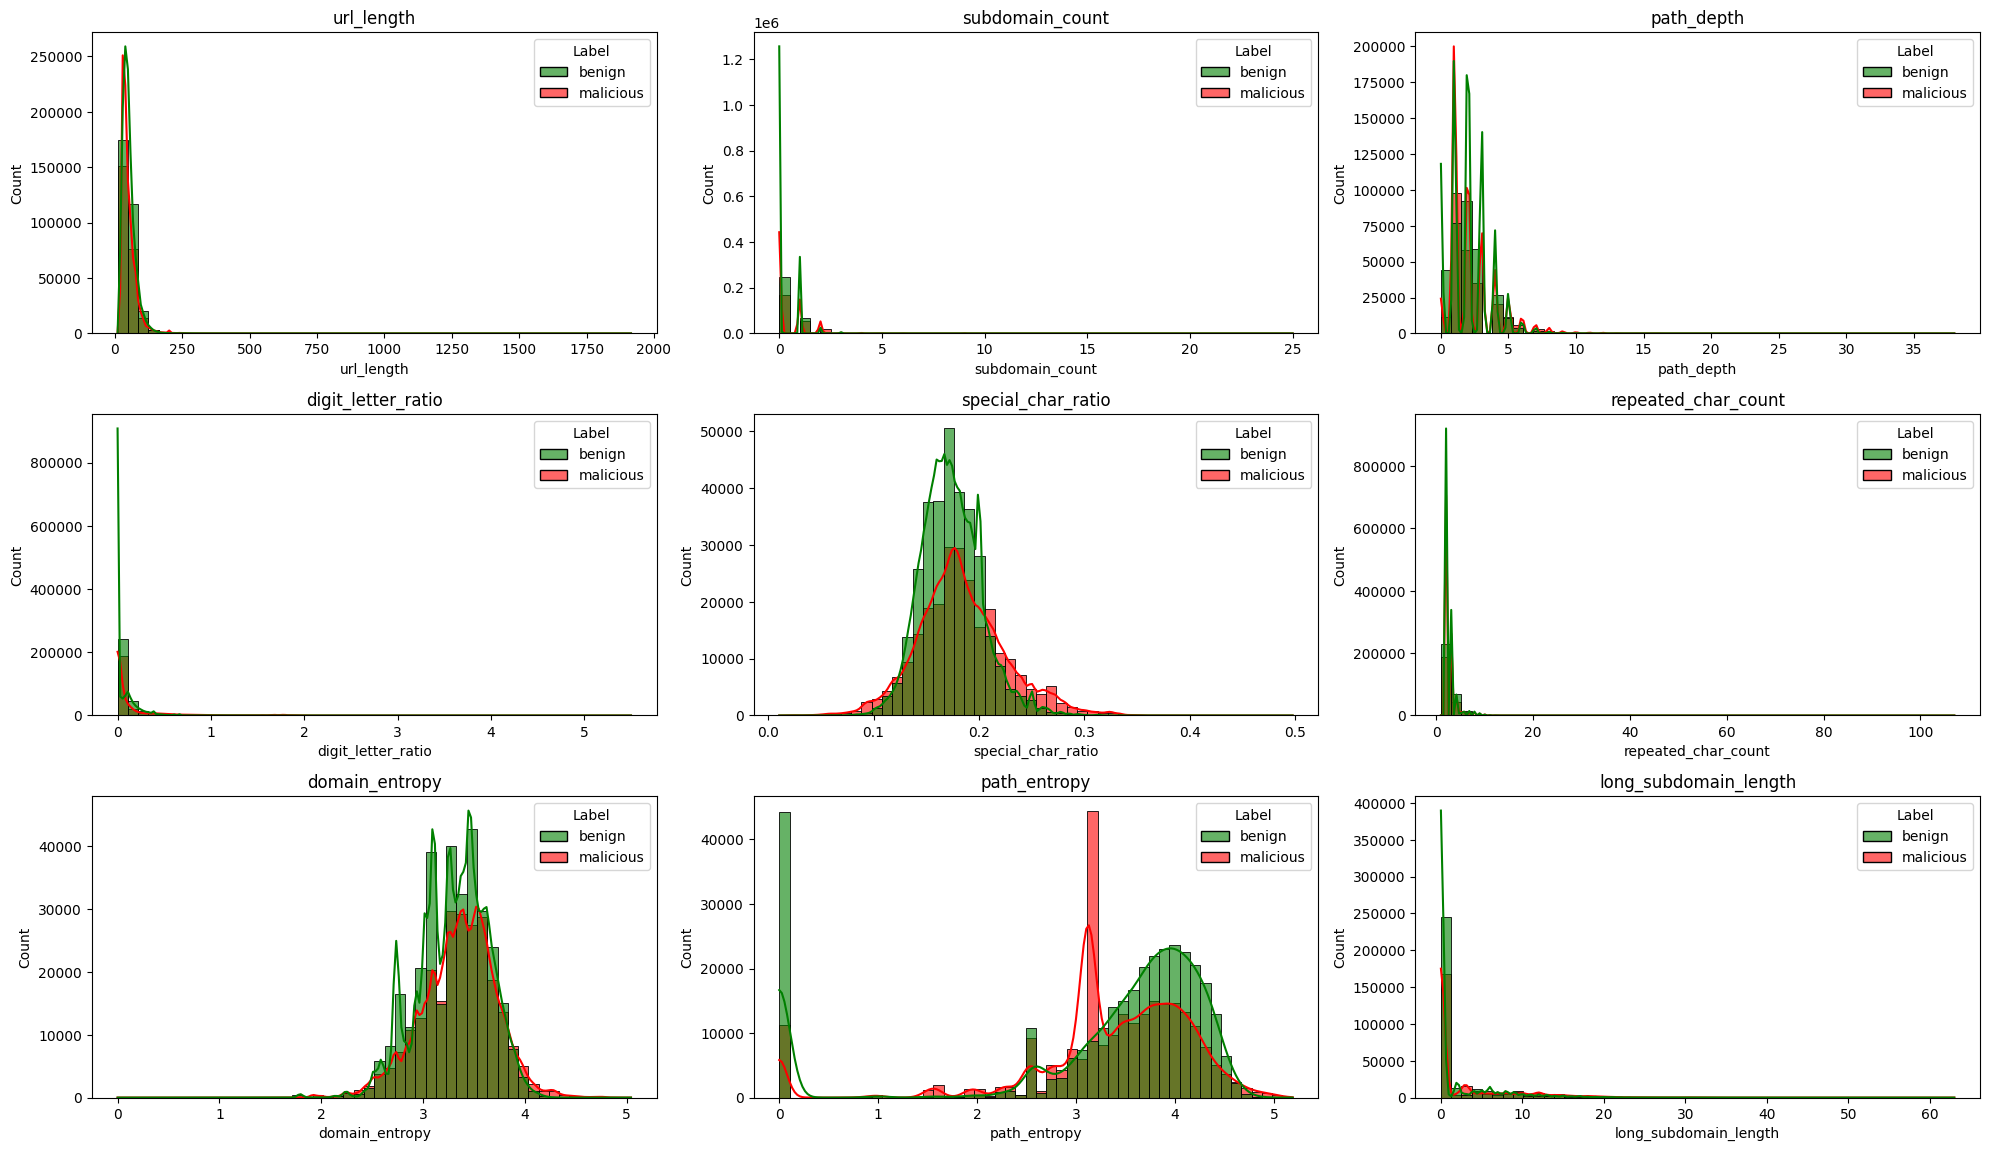

In [32]:
# ===============================
# Plot numeric features
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(4, 3, i+1)
    if df[feature].nunique() > 1:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, kde=True, palette=['green','red'], alpha=0.6)
    else:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

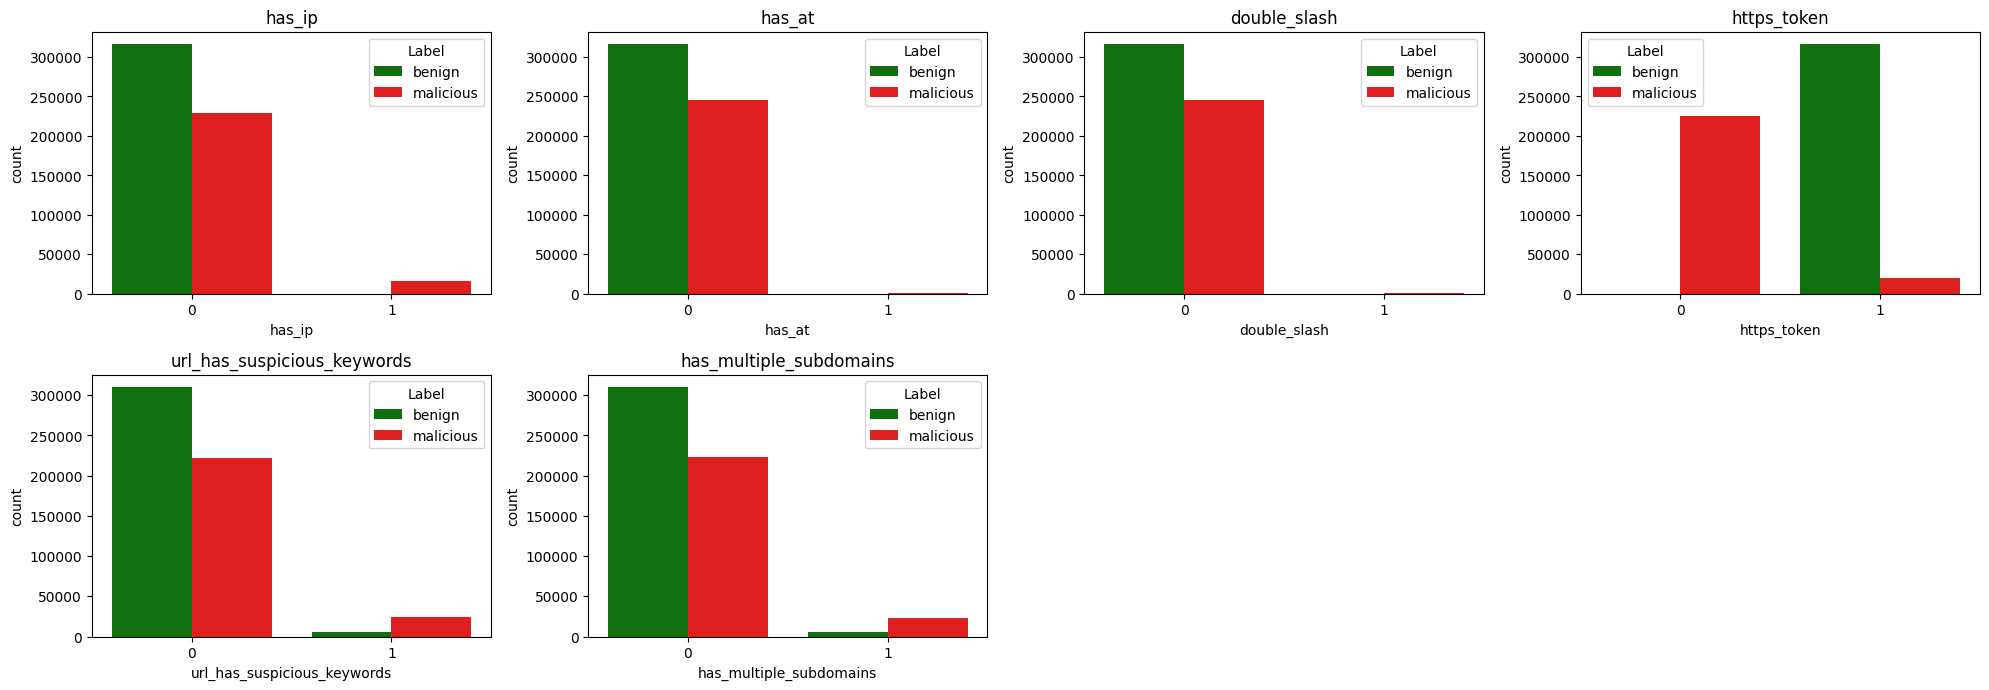

In [33]:
# ===============================
# Plot binary features
# ===============================
plt.figure(figsize=(20, 10))
for i, feature in enumerate(binary_features):
    plt.subplot(3, 4, i+1)
    sns.countplot(x=feature, hue='Label', data=df, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

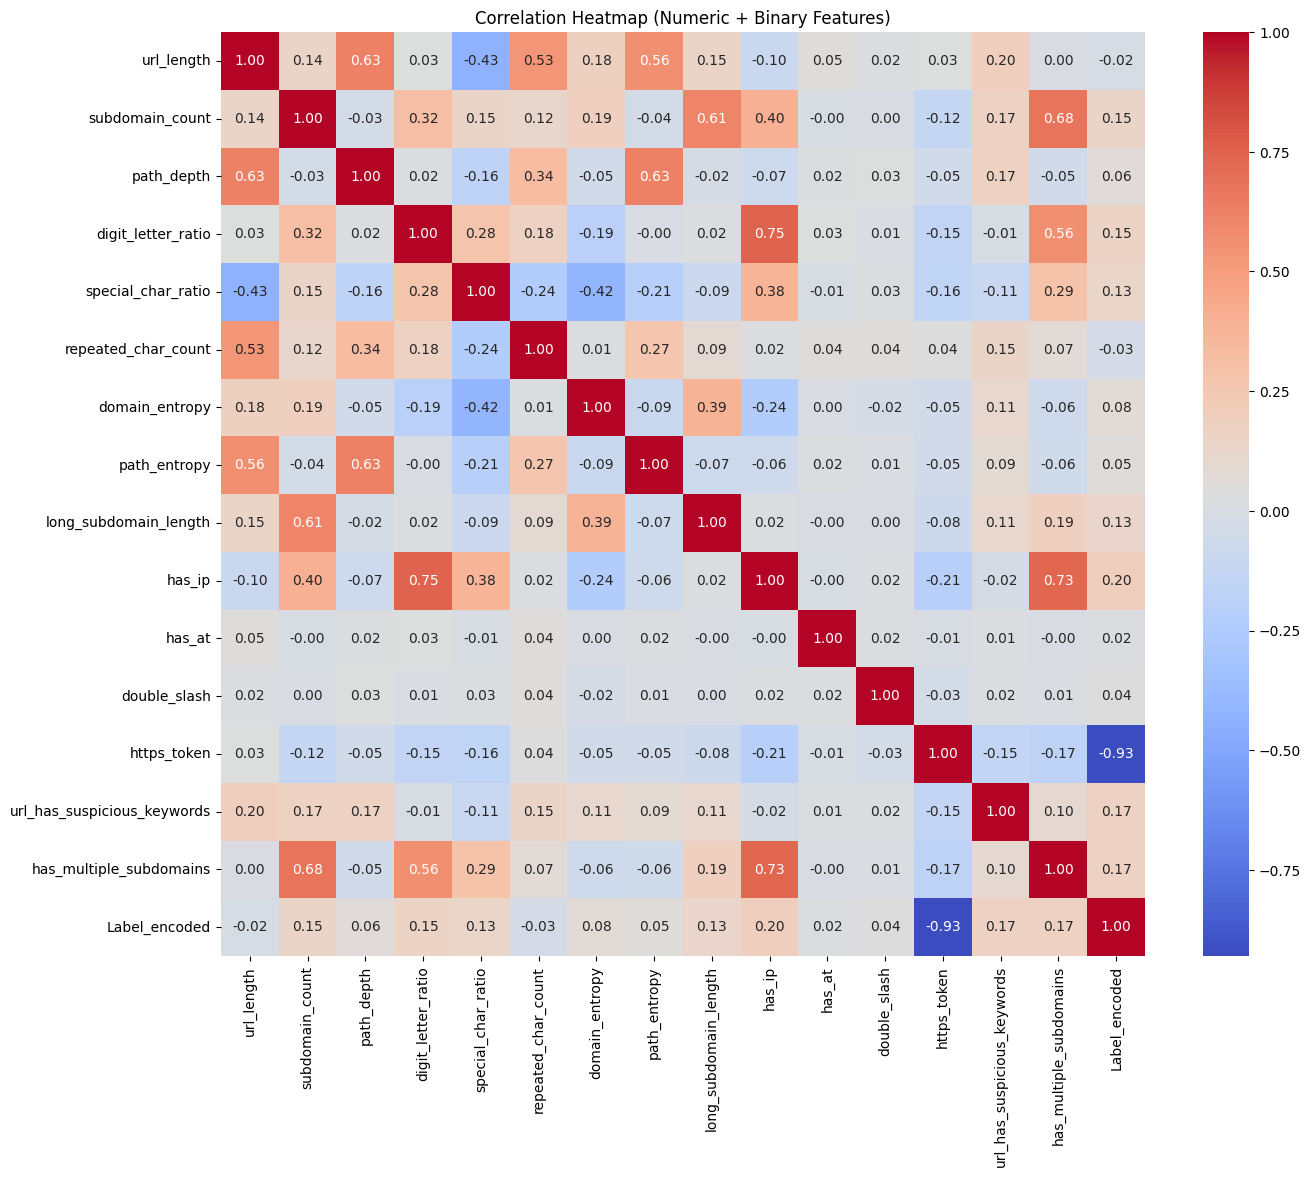

In [34]:
# ===============================
# Correlation heatmap
# ===============================
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_features + binary_features + ['Label_encoded']].corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Numeric + Binary Features)")
plt.show()

In [35]:
# Number of rows and columns
print(df.shape)

# Check for duplicates
print(f"Duplicate URLs: {df['URL'].duplicated().sum()}")

# Check label distribution
print(df['Label'].value_counts())


(562078, 19)
Duplicate URLs: 0
Label
benign       316254
malicious    245824
Name: count, dtype: int64


In [36]:
# Check missing values
print(df.isnull().sum())

URL                            0
Label                          0
URL_normalized                 0
url_length                     0
subdomain_count                0
path_depth                     0
digit_letter_ratio             0
special_char_ratio             0
repeated_char_count            0
domain_entropy                 0
path_entropy                   0
long_subdomain_length          0
has_ip                         0
has_at                         0
double_slash                   0
https_token                    0
url_has_suspicious_keywords    0
has_multiple_subdomains        0
Label_encoded                  0
dtype: int64


REDUCING DATASETS TO 20K

count    562078.000000
mean         65.125032
std          41.581830
min          12.000000
25%          41.000000
50%          55.000000
75%          78.000000
max        2314.000000
Name: url_length, dtype: float64


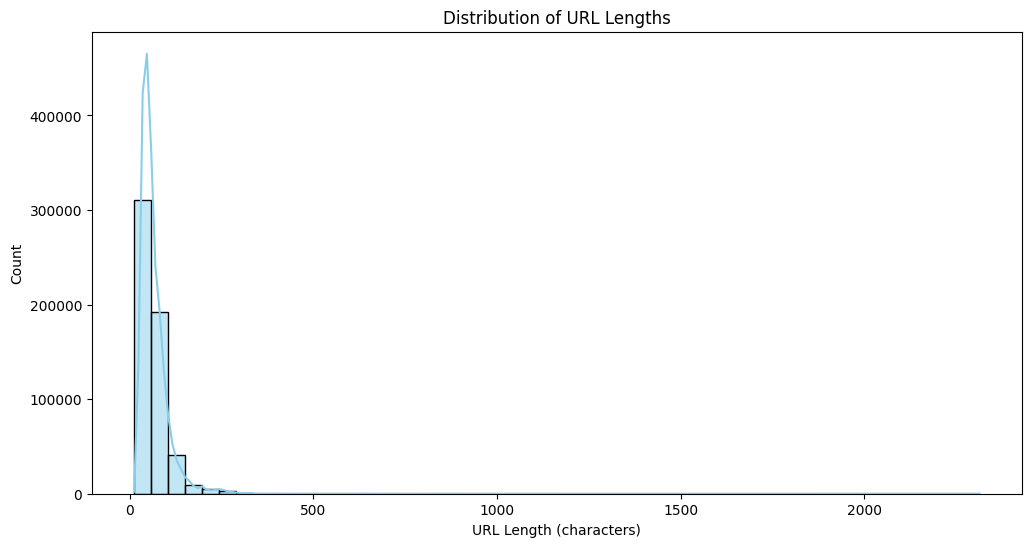

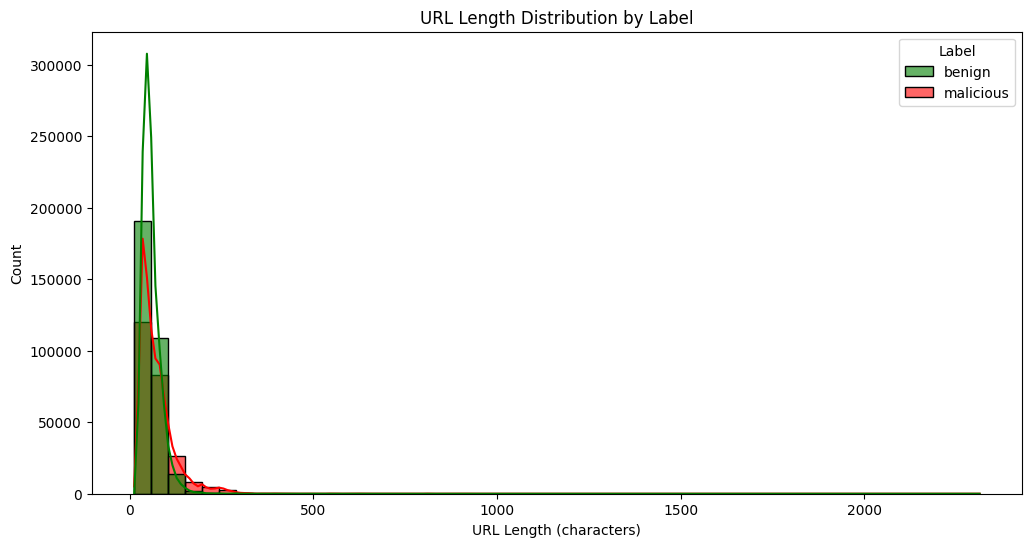

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv(r"D:\QRMODELTRAINING\backend\CSVFILES\ValidUrls.csv")

# Compute URL lengths
df['url_length'] = df['URL'].apply(lambda x: len(str(x)))

# Basic statistics
print(df['url_length'].describe())

# Visualize distribution
plt.figure(figsize=(12,6))
sns.histplot(df['url_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of URL Lengths")
plt.xlabel("URL Length (characters)")
plt.ylabel("Count")
plt.show()

# Optionally, separate by label
plt.figure(figsize=(12,6))
sns.histplot(df, x='url_length', hue='Label', bins=50, kde=True, palette=['green','red'], alpha=0.6)
plt.title("URL Length Distribution by Label")
plt.xlabel("URL Length (characters)")
plt.ylabel("Count")
plt.show()


In [38]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv(r"D:\QRMODELTRAINING\CSVFILES\ValidUrls.csv")

# Define function to classify URL length into bins
def length_category(length):
    if length <= 50:
        return 'short'
    elif length <= 100:
        return 'medium'
    else:
        return 'long'

# Add length category column
df['length_cat'] = df['URL'].apply(lambda x: length_category(len(str(x))))

# ===============================
# Function to sample balanced dataset
# ===============================
def balanced_sample(df, label_col='Label', n_per_class=10000):
    sampled_list = []
    labels = df[label_col].unique()
    for label in labels:
        df_label = df[df[label_col] == label]
        # Determine number of length categories
        length_cats = df_label['length_cat'].value_counts().index.tolist()
        # Compute number per category
        n_cat = n_per_class // len(length_cats)
        # Sample from each length category
        for cat in length_cats:
            df_cat = df_label[df_label['length_cat'] == cat]
            if len(df_cat) >= n_cat:
                sampled = df_cat.sample(n=n_cat, random_state=42)
            else:
                # If not enough, take all
                sampled = df_cat
            sampled_list.append(sampled)
    # Combine and shuffle
    sampled_df = pd.concat(sampled_list).sample(frac=1, random_state=42).reset_index(drop=True)
    return sampled_df

# Get 20k balanced dataset
sampled_df = balanced_sample(df, label_col='Label', n_per_class=10000)

# Check distribution
print(sampled_df['Label'].value_counts())
print(sampled_df['length_cat'].value_counts())

# Save to CSV
sampled_df.to_csv(r"D:\QRMODELTRAINING\CSVFILES\20k_BalancedURLs.csv", index=False)


Label
malicious    9999
benign       9999
Name: count, dtype: int64
length_cat
short     6666
long      6666
medium    6666
Name: count, dtype: int64


CHECK THE LENGTH OF URLS FOR BOTH BENIGN AND MALICIOUS

In [39]:
import pandas as pd

# Load the balanced 20k dataset
df = pd.read_csv(r"D:\QRMODELTRAINING\CSVFILES\20k_BalancedURLs.csv")

# Check total rows and columns
print("Dataset shape:", df.shape)

# Check label distribution
print("\nLabel distribution:")
print(df['Label'].value_counts())

# Check URL length categories
print("\nURL length category distribution:")
print(df['length_cat'].value_counts())

# Optional: check distribution per label
print("\nLength category per label:")
print(df.groupby(['Label', 'length_cat']).size())


Dataset shape: (19998, 3)

Label distribution:
Label
malicious    9999
benign       9999
Name: count, dtype: int64

URL length category distribution:
length_cat
short     6666
long      6666
medium    6666
Name: count, dtype: int64

Length category per label:
Label      length_cat
benign     long          3333
           medium        3333
           short         3333
malicious  long          3333
           medium        3333
           short         3333
dtype: int64
